In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

Using TensorFlow backend.
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/fra

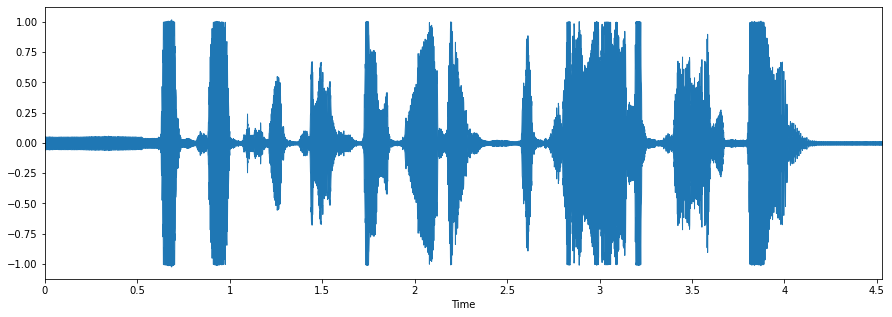

In [7]:
# graph of an original file
fname = '/home/rohit/Desktop/audio_emotion/SAVEE/JK_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

In [8]:
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

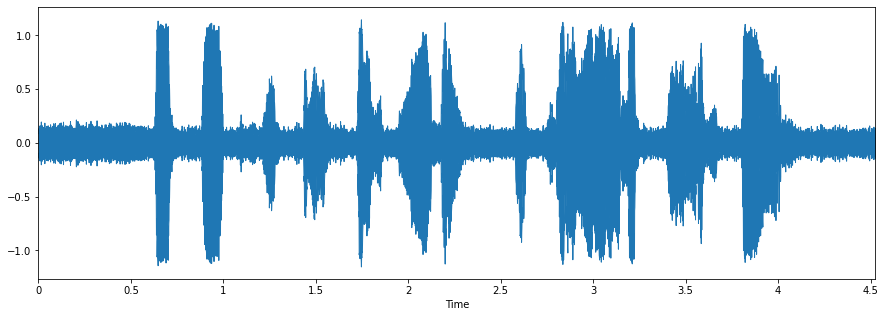

In [9]:
# adding noise to the data
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)


#   

In [10]:
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)


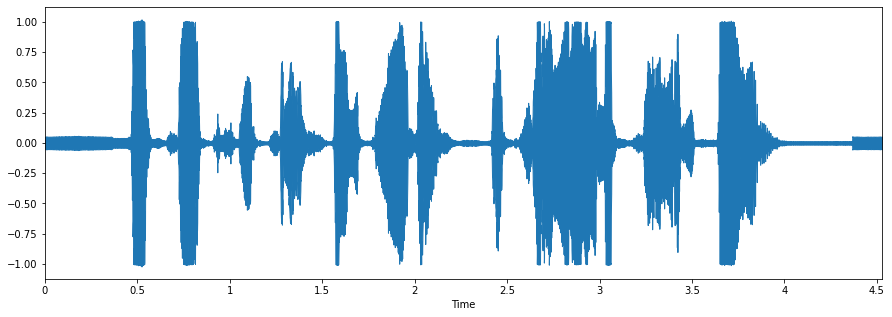

In [11]:
# shifting the data randomly(0.5 sec) to the left or right
x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

#   

In [12]:
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

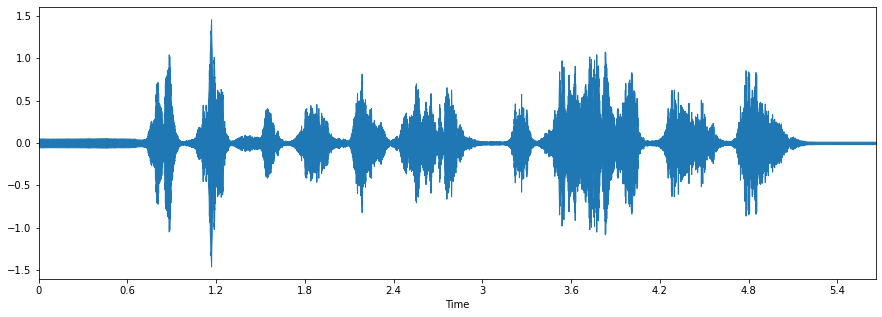

In [13]:
# streching the audio file. Thereby the audio speed becomes slow.
x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

#  

In [14]:
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

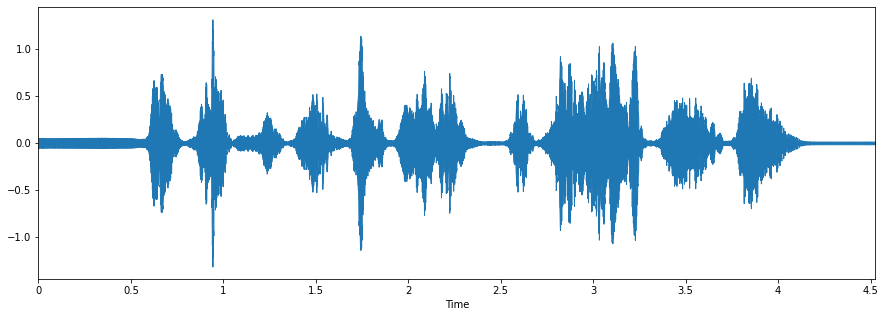

In [15]:
# changes in the pitch of the audio
x = pitch(data, sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

#  

In [16]:
def dyn_change(data):
    """
Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)

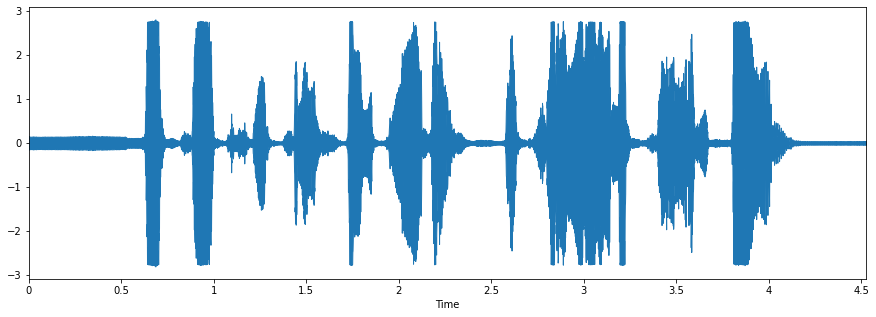

In [17]:
# increasing the min and max value from -1 and 1 to -3 and 3
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

#  

In [18]:
def speedNpitch(data):
    """
    speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data


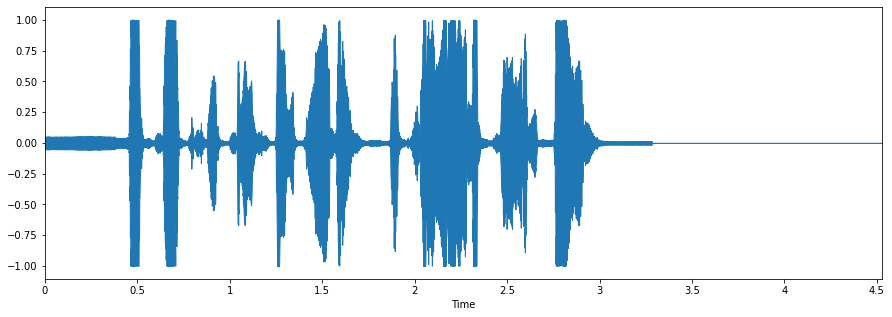

In [19]:
# increasng the speed and altering the pitch of the audio
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

#  

In [20]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("/home/rohit/Desktop/audio_emotion/Data_path.csv")
ref.head()

,labels,source,path
0,male_happy,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JE_h11...
1,male_angry,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_a05...
2,male_neutral,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_n22...
3,male_disgust,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/KL_d06...
4,male_surprise,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/DC_su1...


In [23]:
# Note this takes a couple of minutes (~16 mins) as we're iterating over 4 datasets, and with augmentation  
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

100%|██████████| 12162/12162 [29:18<00:00,  6.92it/s]


,feature
0,"[-21.379093, -21.488506, -22.79399, -21.894154..."
1,"[4.857963, 2.1802883, -2.7702487, -1.9958266, ..."
2,"[-26.060213, -23.547817, -22.635246, -18.16921..."
3,"[-21.454227, -22.888773, -27.012148, -26.95517..."
4,"[-22.758654, -18.710485, -11.95598, -9.946014,..."


In [24]:
# combine 
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

(12162, 219) (12162, 219) (12162, 219)


In [25]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JE_h11...,-21.379093,-21.488506,-22.793989,-21.894154,-21.031609,-22.325092,-22.793335,...,-4.781260,-4.949687,-5.400805,-5.619165,-7.750992,-11.646387,-10.565253,-6.354403,-6.787728,-5.361663
1,male_angry,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_a05...,4.857963,2.180288,-2.770249,-1.995827,-0.780680,-0.125299,-0.136834,...,-27.778399,-27.038452,-26.411522,-25.299252,-25.261127,-24.063915,-24.168633,-23.207539,-23.683941,-23.100679
2,male_neutral,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_n22...,-26.060213,-23.547817,-22.635246,-18.169214,-8.953858,-4.815696,-3.297021,...,-22.929493,-21.727255,-22.926390,-23.176323,-23.170887,-22.713161,-24.315762,-25.440453,-24.207241,-21.705019
3,male_disgust,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/KL_d06...,-21.454227,-22.888773,-27.012148,-26.955172,-27.943380,-30.473011,-33.364262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_surprise,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/DC_su1...,-22.758654,-18.710485,-11.955980,-9.946014,-8.835577,-7.678025,-5.628070,...,-10.005323,-8.823839,-9.212478,-10.346533,-14.636479,-17.771015,-17.927008,-19.199146,-3.393579,4.220823


In [26]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3857,-4.184163,-8.176785,-15.915933,-17.381199,-18.288347,-18.409517,-18.044563,-18.882057,-18.738268,-17.882303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7298,-7.602214,-10.944548,-12.118293,-11.763407,-11.067496,-10.008754,-9.211776,-9.893431,-10.991911,-11.485899,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5874,-18.159916,-17.878401,-17.575996,-16.522917,-16.652391,-17.115314,-16.399837,-16.128441,-18.160559,-18.202147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
858,-49.250671,-45.605484,-44.437050,-43.900528,-45.872559,-46.027256,-45.281509,-46.038357,-46.756393,-46.337097,...,-33.127022,-33.176437,-32.506695,-34.520748,-36.345394,-34.773808,-34.599651,-38.368660,-41.289230,-41.812683
891,-27.297474,-26.196276,-23.712294,-22.642090,-22.008101,-22.220531,-20.963217,-22.439968,-23.843685,-25.580545,...,-13.867184,-13.601231,-14.262829,-15.270800,-15.129582,-14.135885,-14.578968,-15.877965,-17.609970,-16.550634
1748,-48.912178,-47.206875,-47.820072,-45.950768,-45.915733,-47.886246,-48.675381,-47.524979,-47.447441,-48.330727,...,-46.474995,-47.761902,-46.568825,-45.030605,-44.506615,-45.452724,-46.146809,-46.677422,-48.417179,-49.817924
9995,-3.856007,-6.235307,-7.685878,-7.710427,-9.083553,-8.221647,-8.415777,-9.534316,-7.854500,-7.269659,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5771,-16.097862,-14.964046,-17.066648,-17.905895,-17.704599,-16.798388,-17.002083,-14.373888,-13.946705,-11.543314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1029,-40.576084,-40.282059,-40.299362,-40.681438,-40.204056,-39.957291,-40.592289,-40.681438,-40.681438,-40.681438,...,-40.681438,-40.681438,-40.681438,-40.681438,-40.681438,-40.681438,-40.681438,-40.681438,-40.681438,-40.681438
10882,-15.232126,-14.882322,-12.328425,-11.012137,-10.651350,-11.112829,-9.114439,-9.316039,-12.581090,-14.686789,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3857,1.221869,0.992682,0.568053,0.443024,0.363019,0.347508,0.370642,0.300380,0.307180,0.370964,...,0.534649,0.522291,0.522219,0.522823,0.509110,0.509486,0.510263,0.498998,0.496493,0.495082
7298,0.959554,0.770806,0.874674,0.895067,0.942654,1.020638,1.076680,1.018246,0.925761,0.882186,...,0.534649,0.522291,0.522219,0.522823,0.509110,0.509486,0.510263,0.498998,0.496493,0.495082
5874,0.149316,0.214957,0.434019,0.512087,0.494341,0.451209,0.502111,0.520294,0.353313,0.345401,...,0.534649,0.522291,0.522219,0.522823,0.509110,0.509486,0.510263,0.498998,0.496493,0.495082
858,-2.236708,-2.007771,-1.734744,-1.690886,-1.851230,-1.865427,-1.806507,-1.868423,-1.930190,-1.903237,...,-1.192757,-1.220849,-1.184493,-1.287066,-1.414585,-1.328850,-1.314981,-1.540156,-1.700381,-1.723182
891,-0.551935,-0.451841,-0.061426,0.019700,0.064426,0.042142,0.137344,0.016232,-0.100510,-0.244305,...,-0.188454,-0.192338,-0.226628,-0.277810,-0.291671,-0.237815,-0.258825,-0.344857,-0.440480,-0.382970
1748,-2.210730,-2.136146,-2.007890,-1.855861,-1.854695,-2.014382,-2.077792,-1.987150,-1.985373,-2.062575,...,-1.888786,-1.987191,-1.922802,-1.838088,-1.846544,-1.893396,-1.924131,-1.981736,-2.079638,-2.147880
9995,1.247053,1.148320,1.232548,1.221195,1.101909,1.163834,1.140307,1.046926,1.176297,1.219161,...,0.534649,0.522291,0.522219,0.522823,0.509110,0.509486,0.510263,0.498998,0.496493,0.495082
5771,0.307566,0.448585,0.475144,0.400804,0.409878,0.476603,0.453972,0.660419,0.689808,0.877597,...,0.534649,0.522291,0.522219,0.522823,0.509110,0.509486,0.510263,0.498998,0.496493,0.495082
1029,-1.570987,-1.581021,-1.400667,-1.431858,-1.396206,-1.379057,-1.431681,-1.440600,-1.445078,-1.451218,...,-1.586681,-1.615172,-1.613695,-1.610065,-1.644084,-1.641160,-1.635815,-1.663071,-1.668042,-1.663167
10882,0.374006,0.455136,0.857708,0.955518,0.976059,0.932172,1.084460,1.064358,0.798858,0.626360,...,0.534649,0.522291,0.522219,0.522823,0.509110,0.509486,0.510263,0.498998,0.496493,0.495082


In [28]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(27364, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [29]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape


(27364, 216, 1)

In [30]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 256)         

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=80, validation_data=(X_test, y_test),verbose=2)

Train on 27364 samples, validate on 9122 samples
Epoch 1/80
 - 683s - loss: 2.0144 - accuracy: 0.3017 - val_loss: 2.0749 - val_accuracy: 0.3165
Epoch 2/80
 - 682s - loss: 1.9419 - accuracy: 0.3263 - val_loss: 2.0150 - val_accuracy: 0.3371
Epoch 3/80
 - 681s - loss: 1.8900 - accuracy: 0.3405 - val_loss: 1.9710 - val_accuracy: 0.3554
Epoch 4/80
 - 681s - loss: 1.8486 - accuracy: 0.3574 - val_loss: 1.9332 - val_accuracy: 0.3599
Epoch 5/80
 - 683s - loss: 1.8140 - accuracy: 0.3690 - val_loss: 1.9161 - val_accuracy: 0.3635
Epoch 6/80
 - 681s - loss: 1.7842 - accuracy: 0.3793 - val_loss: 1.8793 - val_accuracy: 0.3699
Epoch 7/80
 - 681s - loss: 1.7549 - accuracy: 0.3945 - val_loss: 1.8497 - val_accuracy: 0.3853
Epoch 8/80
 - 681s - loss: 1.7316 - accuracy: 0.3981 - val_loss: 1.8442 - val_accuracy: 0.3937
Epoch 9/80
 - 681s - loss: 1.7089 - accuracy: 0.4036 - val_loss: 1.8253 - val_accuracy: 0.3916
Epoch 10/80
 - 684s - loss: 1.6906 - accuracy: 0.4121 - val_loss: 1.8250 - val_accuracy: 0.3868


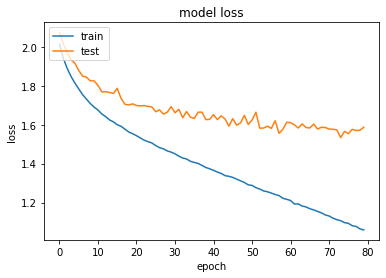

In [33]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# Save model and weights
model_name = 'Emotion_Model_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /home/rohit/Desktop/audio_emotion/saved_models/Emotion_Model_aug.h5 


In [37]:
# loading json and model architecture 
json_file = open('model_json_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 45.11%


In [38]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

9122/9122 [==============================] - 67s 7ms/step


array([2, 2, 5, ..., 2, 2, 8])

In [39]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_surprise,female_surprise
171,female_fear,female_fear
172,female_neutral,female_neutral
173,female_fear,female_fear
174,male_neutral,male_neutral
175,male_disgust,female_fear
176,female_fear,female_fear
177,female_disgust,female_disgust
178,male_surprise,male_surprise
179,male_fear,female_neutral


In [40]:
# Write out the predictions to disk
finaldf.to_csv('Predictions_aug.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,804
female_disgust,1234
female_fear,1115
female_happy,676
female_neutral,808
female_sad,1311
female_surprise,381
male_angry,261
male_disgust,495


In [41]:
####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.45110721333041


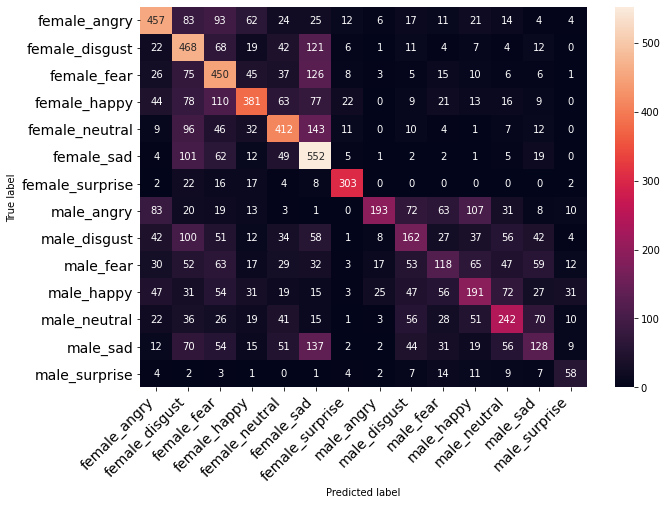

In [43]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions_aug.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [44]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.57      0.55      0.56       833
 female_disgust       0.38      0.60      0.46       785
    female_fear       0.40      0.55      0.47       813
   female_happy       0.56      0.45      0.50       843
 female_neutral       0.51      0.53      0.52       783
     female_sad       0.42      0.68      0.52       815
female_surprise       0.80      0.81      0.80       374
     male_angry       0.74      0.31      0.44       623
   male_disgust       0.33      0.26      0.29       634
      male_fear       0.30      0.20      0.24       597
     male_happy       0.36      0.29      0.32       649
   male_neutral       0.43      0.39      0.41       620
       male_sad       0.32      0.20      0.25       630
  male_surprise       0.41      0.47      0.44       123

       accuracy                           0.45      9122
      macro avg       0.47      0.45      0.44      9122
   weighted avg       0.46   

0.8163779872834904


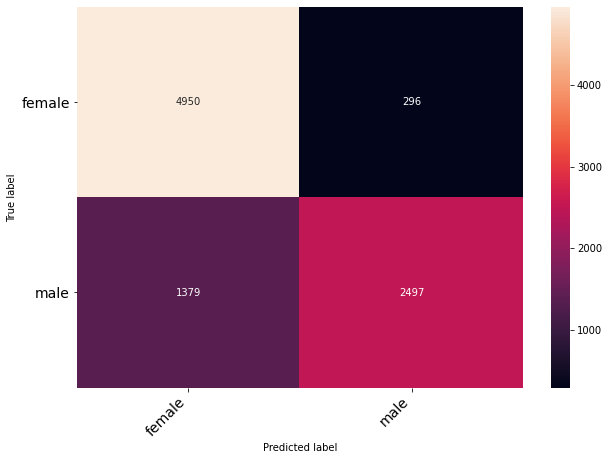

In [45]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [46]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))


              precision    recall  f1-score   support

      female       0.78      0.94      0.86      5246
        male       0.89      0.64      0.75      3876

    accuracy                           0.82      9122
   macro avg       0.84      0.79      0.80      9122
weighted avg       0.83      0.82      0.81      9122



0.5094277570708178


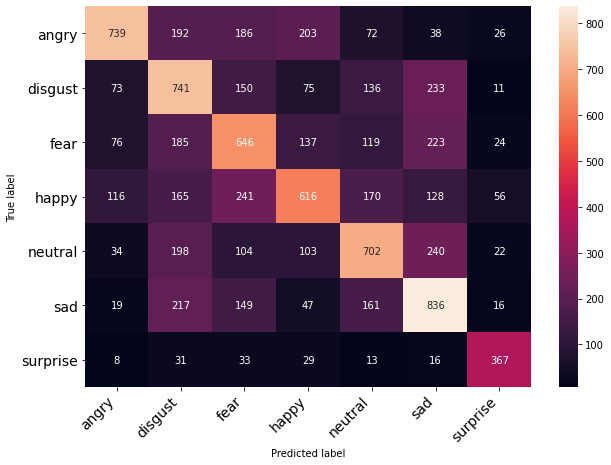

In [47]:
modidf = pd.read_csv("Predictions_aug.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [48]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))


              precision    recall  f1-score   support

       angry       0.69      0.51      0.59      1456
     disgust       0.43      0.52      0.47      1419
        fear       0.43      0.46      0.44      1410
       happy       0.51      0.41      0.46      1492
     neutral       0.51      0.50      0.51      1403
         sad       0.49      0.58      0.53      1445
    surprise       0.70      0.74      0.72       497

    accuracy                           0.51      9122
   macro avg       0.54      0.53      0.53      9122
weighted avg       0.52      0.51      0.51      9122



#  

#  

### OBSERVATION

1) We increase the data points for training model using Data Augmentation. The model performance increased to 45.11% when we consider the male and female emotions to be of different class. The class whose prediction score was poor has drastically improved (male surprise).

2) The model was able to differentiate gender using the features with an accuracy of 81.63%. The model performed a little better for Female gender classification when compared with male gender. But the model has learnt better than Baseline model.

3) When not considering the gender, the model was giving an accuracy score of 50.94%. THe performance of each class was similar except for one class. The class(male surprise) whose prediction score was poor has drastically improved.